
情感标签的分布：
sentiment
Negative    54613
Positive    45622
Neutral     11878
Name: count, dtype: int64


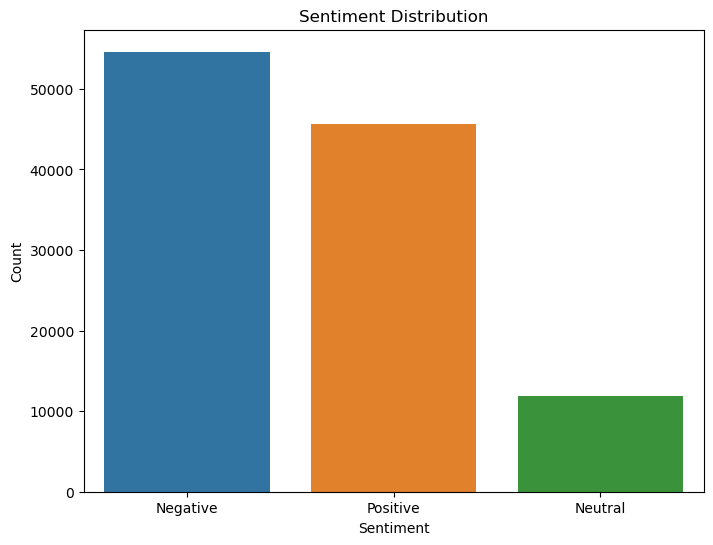


文本长度的描述性统计：
count    112113.000000
mean        158.328695
std         111.709309
min           1.000000
25%          85.000000
50%         124.000000
75%         196.000000
max        1752.000000
Name: text_length, dtype: float64


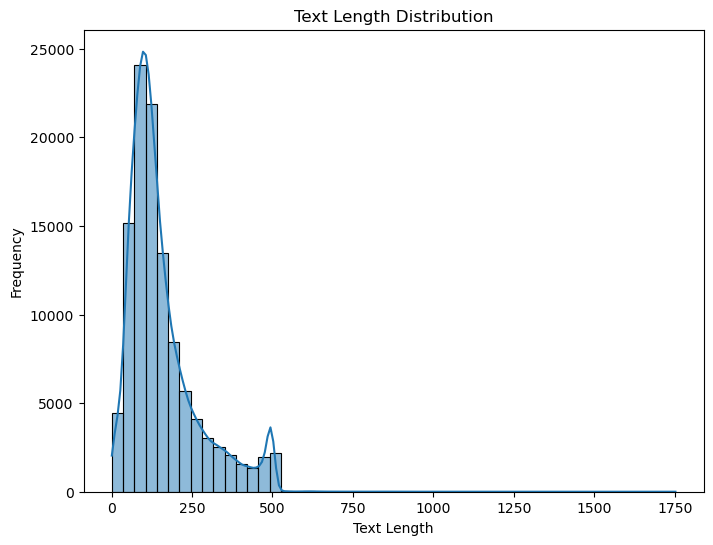

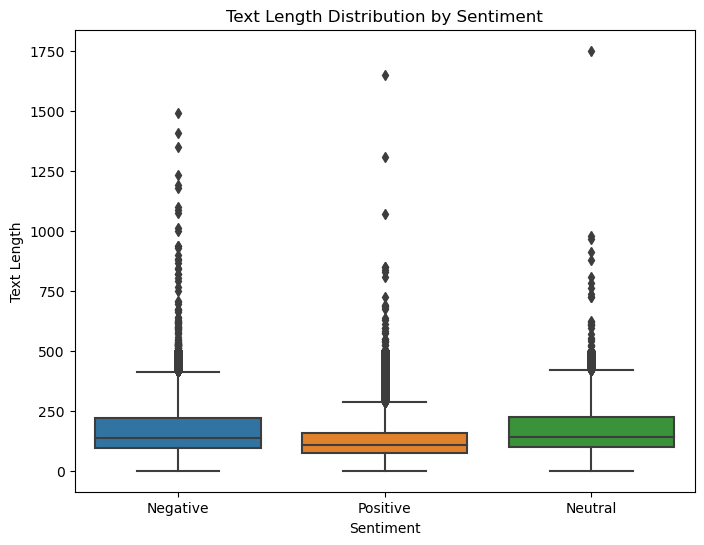

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设数据集文件名为 netflix_reviews.csv
df = pd.read_csv('netflix_reviews.csv')

# 创建情感标签列，基于score列
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)

# 检查情感标签的分布
print("\n情感标签的分布：")
print(df['sentiment'].value_counts())

# 可视化情感标签的分布
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 分析文本长度分布
df['text_length'] = df['content'].apply(lambda x: len(str(x)))
print("\n文本长度的描述性统计：")
print(df['text_length'].describe())

# 可视化文本长度分布
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 各情感标签下的文本长度分布
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()


模型准确率: 79.55%

分类报告:
              precision    recall  f1-score   support

    Negative       0.79      0.91      0.85     10923
     Neutral       0.33      0.06      0.10      2376
    Positive       0.82      0.85      0.83      9124

    accuracy                           0.80     22423
   macro avg       0.65      0.61      0.59     22423
weighted avg       0.75      0.80      0.76     22423



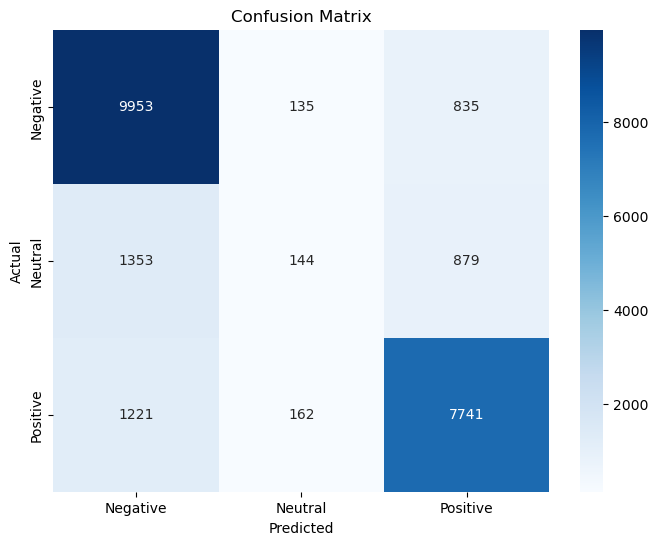

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据集
df = pd.read_csv('netflix_reviews.csv')

# 创建情感标签列
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)

# 数据预处理：移除缺失值
df = df.dropna(subset=['content'])

# 将文本和标签分开
X = df['content']
y = df['sentiment']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征提取：使用TF-IDF向量化
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# 训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = model.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [4]:
# 调整类权重，使模型更加关注中性情感
model = LogisticRegression(max_iter=1000, class_weight={'Negative': 1, 'Neutral': 3, 'Positive': 1})
model.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = model.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

模型准确率: 75.44%

分类报告:
              precision    recall  f1-score   support

    Negative       0.83      0.82      0.83     10923
     Neutral       0.25      0.37      0.30      2376
    Positive       0.87      0.77      0.82      9124

    accuracy                           0.75     22423
   macro avg       0.65      0.66      0.65     22423
weighted avg       0.79      0.75      0.77     22423



In [5]:
# 调整类权重，使模型更加关注中性情感  neutral: 3 -->2
model = LogisticRegression(max_iter=1000, class_weight={'Negative': 1, 'Neutral': 2, 'Positive': 1})
model.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = model.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

模型准确率: 78.04%

分类报告:
              precision    recall  f1-score   support

    Negative       0.82      0.87      0.84     10923
     Neutral       0.29      0.24      0.26      2376
    Positive       0.84      0.81      0.83      9124

    accuracy                           0.78     22423
   macro avg       0.65      0.64      0.64     22423
weighted avg       0.77      0.78      0.77     22423



In [14]:
# 超参数调优（网格搜索） 使用网格搜索来优化逻辑回归的正则化参数。
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2 penalties
}

# 实例化逻辑回归模型
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# 网格搜索
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_tfidf, y_train)

# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数训练模型
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))


最佳参数: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
模型准确率: 78.04%

分类报告:
              precision    recall  f1-score   support

    Negative       0.83      0.86      0.84     10923
     Neutral       0.28      0.27      0.28      2376
    Positive       0.85      0.82      0.83      9124

    accuracy                           0.78     22423
   macro avg       0.65      0.65      0.65     22423
weighted avg       0.78      0.78      0.78     22423



模型准确率: 73.04%

分类报告:
              precision    recall  f1-score   support

    Negative       0.86      0.75      0.80     10923
     Neutral       0.24      0.51      0.33      2376
    Positive       0.88      0.76      0.82      9124

    accuracy                           0.73     22423
   macro avg       0.66      0.67      0.65     22423
weighted avg       0.80      0.73      0.76     22423



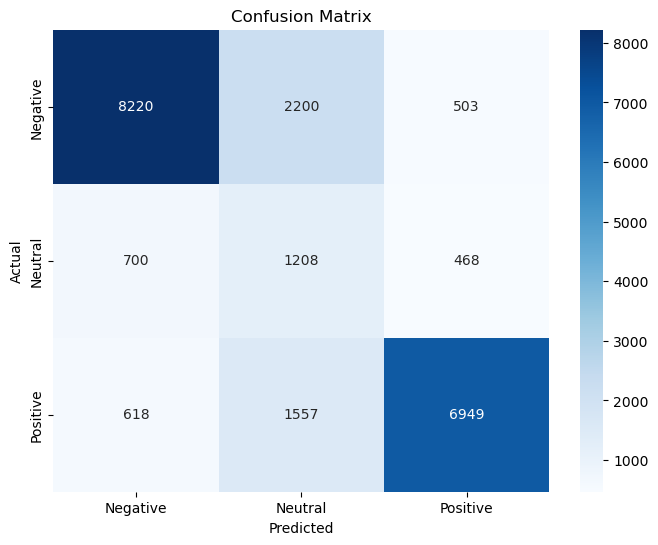

In [6]:
# 特征提取优化

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df 是已有的原始数据集
df2 = df.copy()  # 复制 df 为 df2，以避免对原数据集的影响

# 创建情感标签列
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df2['sentiment'] = df2['score'].apply(label_sentiment)

# 数据预处理：移除缺失值
df2 = df2.dropna(subset=['content'])

# 将文本和标签分开
X = df2['content']
y = df2['sentiment']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征提取：使用TF-IDF向量化，提取单词和双词特征
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 训练逻辑回归模型
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = model.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


模型准确率: 72.69%

分类报告:
              precision    recall  f1-score   support

    Negative       0.86      0.75      0.80     10923
     Neutral       0.24      0.50      0.32      2376
    Positive       0.88      0.76      0.81      9124

    accuracy                           0.73     22423
   macro avg       0.66      0.67      0.65     22423
weighted avg       0.80      0.73      0.76     22423



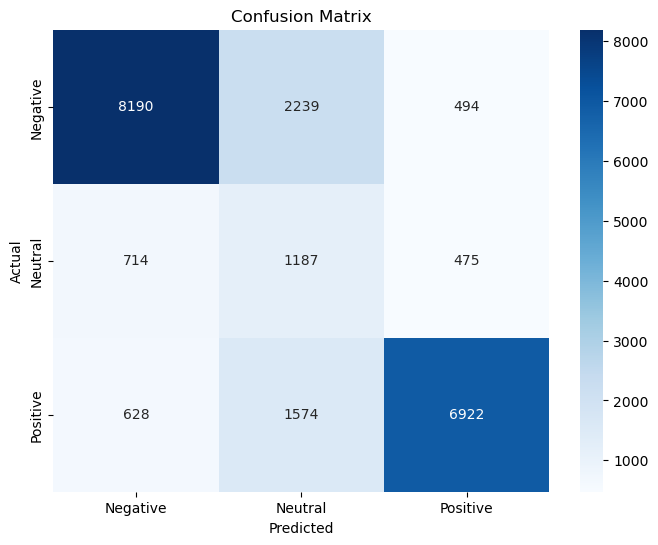

In [7]:
# 特征提取优化2
from sklearn.feature_extraction.text import TfidfVectorizer

# 特征提取：使用TF-IDF向量化，提取单词、双词和三词特征
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 训练逻辑回归模型
model = LogisticRegressi on(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = model.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

模型准确率: 79.19%

分类报告:
              precision    recall  f1-score   support

    Negative       0.78      0.92      0.85     10923
     Neutral       0.35      0.07      0.11      2376
    Positive       0.83      0.83      0.83      9124

    accuracy                           0.79     22423
   macro avg       0.65      0.60      0.60     22423
weighted avg       0.75      0.79      0.76     22423



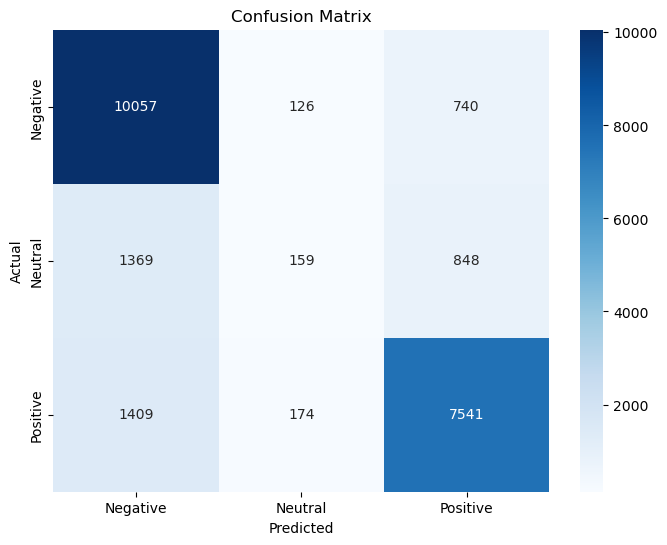

In [8]:
# 集成学习
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# 定义模型
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 使用投票法进行模型集成
voting_clf = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model)], voting='soft')
voting_clf.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = voting_clf.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


D:\Anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


模型准确率: 79.27%

分类报告:
              precision    recall  f1-score   support

    Negative       0.78      0.92      0.85     10923
     Neutral       0.35      0.05      0.08      2376
    Positive       0.83      0.83      0.83      9124

    accuracy                           0.79     22423
   macro avg       0.65      0.60      0.59     22423
weighted avg       0.75      0.79      0.76     22423



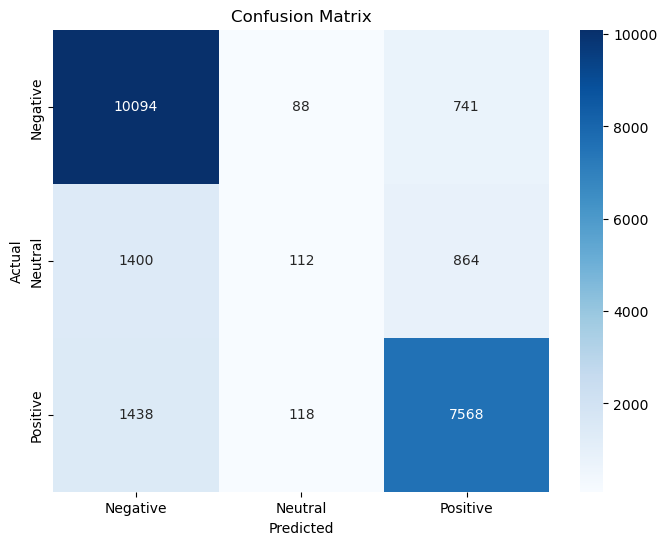

In [10]:
# 采用更多集成模型
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# 定义更多模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# 使用投票法进行模型集成
voting_clf = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model)], voting='soft')
voting_clf.fit(X_train_tfidf, y_train)

# 模型预测
y_pred = voting_clf.predict(X_test_tfidf)

# 模型评估
print("模型准确率: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()